Import Tools

In [1]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer
import torch


In [11]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = "cpu"
print(f"Using device : {device}")


Using device : mps


Load Datasets

In [3]:
df = pd.read_csv("./domain_specific_chatbot_data.csv")

df.head()  # Displays first few rows of dataset

,query,response,intent,domain
0,What are the side effects of the COVID-19 vacc...,Common side effects of the COVID-19 vaccine in...,side effects inquiry,healthcare
1,How can I schedule an appointment with my doctor?,You can schedule an appointment by calling our...,appointment booking,healthcare
2,What should I do if I miss a dose of my medica...,"If you miss a dose, take it as soon as you rem...",medication inquiry,healthcare
3,How can I check my account balance?,You can check your balance by logging into you...,balance inquiry,finance
4,What is the interest rate for a personal loan?,The current interest rate for personal loans i...,loan inquiry,finance


Data Preprocessing

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df.shape, test_df.shape

((2400, 4), (600, 4))

In [5]:
# Reset index to 0
train_data = train_df.reset_index(drop=True)
test_data = test_df.reset_index(drop=True)

In [6]:
# Cleaning datasets
import re

def clean_text(text):
    text = re.sub(r'\r\n', ' ', text)  # Removes newlines
    text = re.sub(r'\s', ' ', text)    # Replaces all whitespace with single space
    text = re.sub(r'<.*?>', '', text)  # Removes HTML tags
    text = text.strip().lower()
    return text


In [7]:
# Apply clean_text function
train_data['query'] = train_data['query'].apply(clean_text)
train_data['response'] = train_data['response'].apply(clean_text)

test_data['query'] = test_data['query'].apply(clean_text)
test_data['response'] = test_data['response'].apply(clean_text)


Tokenization

In [8]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [9]:
# Preprocessing function for tokenization
def preprocess_function(dataset):
    inputs = tokenizer(dataset['query'], padding="max_length", truncation=True, max_length=250)
    targets = tokenizer(dataset['response'], padding="max_length", truncation=True, max_length=250)
    inputs['labels'] = targets['input_ids']  # Sets the tokenized response text as the labels for training.
    return inputs

# Apply the preprocessing
train_dataset = train_data.apply(preprocess_function, axis= 1)
test_dataset = test_data.apply(preprocess_function, axis= 1)

Fine Tuning Model

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("t5-base")
model = model.to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_steps=500,
    eval_steps=50,
    evaluation_strategy="epoch"
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

/Users/sujannainawasti/.pyenv/versions/3.9.13/lib/python3.9/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss
1,0.029300,0.006550
2,0.001600,0.000035
3,0.000500,0.000009
4,0.000400,0.000006
5,0.000300,0.000004
6,0.000300,0.000004


TrainOutput(global_step=1800, training_loss=0.6166053186920989, metrics={'train_runtime': 8927.4431, 'train_samples_per_second': 1.613, 'train_steps_per_second': 0.202, 'total_flos': 4281735168000000.0, 'train_loss': 0.6166053186920989, 'epoch': 6.0})

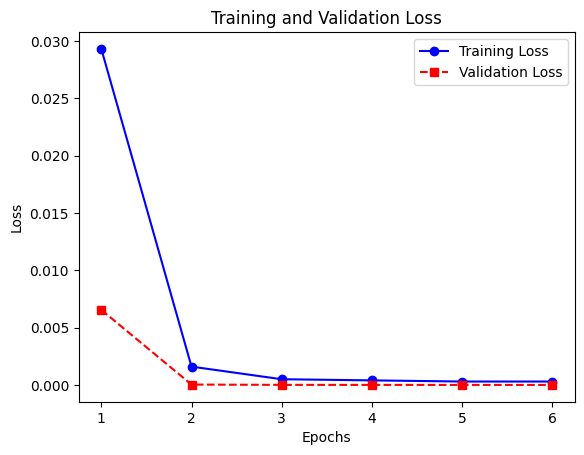

In [17]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4, 5, 6]
training_loss = [0.0293, 0.0016, 0.0005, 0.0004, 0.0003, 0.0003]
validation_loss = [0.00655, 0.000035, 0.000009, 0.000006, 0.000004, 0.000004]

df = pd.DataFrame({'Epoch': epochs, 'Training Loss': training_loss, 'Validation Loss': validation_loss})
df.to_csv("training_data.csv", index=False)

plt.plot(epochs, training_loss, marker='o', linestyle='-', color='b', label="Training Loss")
plt.plot(epochs, validation_loss, marker='s', linestyle='--', color='r', label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.show()


Save and Load Model

In [ ]:
# save model
model.save_pretrained("./chatbot_model")
tokenizer.save_pretrained("./chatbot_model")


In [12]:
# load model
model = T5ForConditionalGeneration.from_pretrained("./chatbot_model").to(device)
tokenizer = T5Tokenizer.from_pretrained("./chatbot_model")

Chatbot System

In [13]:
def chatbot(query):
    query = clean_text(query)
    input_ids = tokenizer(query, return_tensors='pt', max_length=250, truncation=True)

    inputs = {key: value.to(device) for key, value in input_ids.items() }

    outputs = model.generate(
        inputs["input_ids"],
        max_length=250,
        num_beams=5,
        early_stopping=True
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [15]:
# while True:
#     user_input = input("You: ")
#     if user_input.lower()=="exit":
#         break
#     response = chatbot(user_input)
#     print(f"Chatbot: {response}")


In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create a text input field
user_input = widgets.Text(placeholder="Type your message and press Enter...", layout=widgets.Layout(width="80%"))

# Create an output area
output = widgets.Output()

# Function to handle input submission
def on_input_submit(sender):
    with output:
        # Get user input
        message = user_input.value.strip()
        
        # Check if the input is empty
        if not message:
            return
        
        # Check if the user wants to exit
        if message.lower() == "exit":
            print("Chatbot: Goodbye!")
            user_input.disabled = True  # Disable input field
            return
        
        # Get chatbot response
        response = chatbot(message)
        
        # Display the conversation
        print(f"You: {message}")
        print(f"Chatbot: {response}\n")
        
        # Clear the input field (after processing)
        user_input.value = ""

# Link function to the "Enter" key press
user_input.on_submit(on_input_submit)

# Display the widgets
display(user_input, output)

/var/folders/n3/lsbnbfr506q92gbtjsmwsxs80000gn/T/ipykernel_3252/257334810.py:37: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  user_input.on_submit(on_input_submit)


Text(value='', layout=Layout(width='80%'), placeholder='Type your message and press Enter...')

Output()